This is an example of merging precipitation data with the PFAS file. The precipitation data is for Orange County, 2010-2019 and was accessed from the NOAA Climate Data Online Search (https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND)

In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

prec=pd.read_csv("precip_2010_2019.csv")[['STATION','LATITUDE','LONGITUDE','ELEVATION','DATE','PRCP','TAVG','TMAX','TMIN']]
dat=pd.read_excel("SAR-Imperial_537Data_AsOf08-08-2019.xlsx",sheet_name='All')

In [2]:
#Merge the data by the date?
prec['DATE']=pd.to_datetime(prec['DATE'])
dat_merged=pd.merge(prec,dat,left_on='DATE',right_on='Sample Date')

In [3]:
dat_merged.head()

,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN,Station Name,...,Parameter Abbreviation,Sample Date,Sample Time,Result Value (10% of RDL for NDs),Result Text,Units,RDL,Detected (Y: Yes; N: No),Laboratory Sample Number,Method
0,US1CAOR0047,33.5692,-117.6362,164.0,2016-06-14,0.0,NaN,NaN,NaN,SAR-IMPERIAL-01,...,PFBS,2016-06-14,12:10:00,9.0,ND,ng/L,90,N,16060368-19,537
1,US1CAOR0047,33.5692,-117.6362,164.0,2016-06-14,0.0,NaN,NaN,NaN,SAR-IMPERIAL-01,...,PFHpA,2016-06-14,12:10:00,1.0,ND,ng/L,10,N,16060368-19,537
2,US1CAOR0047,33.5692,-117.6362,164.0,2016-06-14,0.0,NaN,NaN,NaN,SAR-IMPERIAL-01,...,PFHxS,2016-06-14,12:10:00,3.0,ND,ng/L,30,N,16060368-19,537
3,US1CAOR0047,33.5692,-117.6362,164.0,2016-06-14,0.0,NaN,NaN,NaN,SAR-IMPERIAL-01,...,PFNA,2016-06-14,12:10:00,2.0,ND,ng/L,20,N,16060368-19,537
4,US1CAOR0047,33.5692,-117.6362,164.0,2016-06-14,0.0,NaN,NaN,NaN,SAR-IMPERIAL-01,...,PFOS,2016-06-14,12:10:00,4.0,ND,ng/L,40,N,16060368-19,537


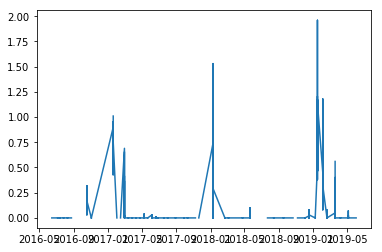

In [12]:
dat_sort=dat_merged.sort_values(by=['DATE'])
plt.plot(dat_sort['DATE'],dat_sort['PRCP'])

In [13]:
dat_sort.to_csv('SAR-Imperial_merged_precip.csv',index=False)